In [86]:
import os
import sys

# Get the current working directory
current_dir = os.getcwd()
# Add the ./src folder to the Python module search path
sys.path.append(os.path.join(current_dir, '..', 'src'))

from utils import *
from optimize import *
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression

import xgboost as xgb

sns.set_style('ticks')

We use the best parameter combo discovered so far to see some details of the peroformance.

## 0. Read and inspect data files

In [87]:
input_path = '../Data'

feature_file = 'Mordred_reduced_features.npy'
features_file_2 =  'deepnose_features.npy'

CID_file = 'molecules_train_cid.npy'

mixture_file = 'Mixure_Definitions_Training_set.csv'
intensity_file = 'Mixure_Definitions_Intensity_Training_set.csv'
training_task_file = 'TrainingData_mixturedist.csv'

features_1 = np.load(os.path.join(input_path, feature_file))
features_2 = np.load(os.path.join(input_path, features_file_2))

# Training dataframe
training_set = pd.read_csv(os.path.join(input_path, training_task_file))

# Mapping helper files
mixtures_IDs = pd.read_csv(os.path.join(input_path, mixture_file))
mixtures_intensities = pd.read_csv(os.path.join(input_path, intensity_file))

features_CIDs = np.load(os.path.join(input_path, CID_file))

In [88]:
# Define the scaling constant
scaling_constant = 2  # Adjust this value as needed

# Get the list of column names containing "CID"
cid_columns = [col for col in mixtures_intensities.columns if 'CID' in col]

# Create a mask to identify rows where "Dataset" is in ['Snitz 1', 'Snitz 2', 'Bushdid']
mask = mixtures_intensities['Dataset'].isin(['Snitz 1', 'Snitz 2', 'Bushdid'])

# Scale the values of "CID" columns for the selected rows
mixtures_intensities.loc[mask, cid_columns] *= scaling_constant

In [89]:
mixtures_intensities

,Dataset,Mixture Label,CID,CID.1,CID.2,CID.3,CID.4,CID.5,CID.6,CID.7,...,CID.48,CID.49,CID.50,CID.51,CID.52,CID.53,CID.54,CID.55,CID.56,CID.57
0,Snitz 1,1,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Snitz 1,2,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Snitz 1,3,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Snitz 1,4,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Snitz 1,5,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,Bushdid,516,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
699,Bushdid,517,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
700,Bushdid,518,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
701,Bushdid,519,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
scaler = StandardScaler(with_mean=True, with_std=True)
features_1 = scaler.fit_transform(features_1)
epsilon = 1e-8
features_2 = scaler.fit_transform(np.log(features_2 + epsilon))

In [91]:
features = np.hstack((features_1, features_2))

In [92]:
# Map CID to 96 dim features:
CID2features =  {CID: features[i] for i, CID in enumerate(features_CIDs)}

----

## 1. Organize mixture training dataset

In [93]:
def intensity_function(x, alpha_int = 1.3, beta_int = 0.07):
    return 1 / (1 + np.exp(-(x - alpha_int)/beta_int))

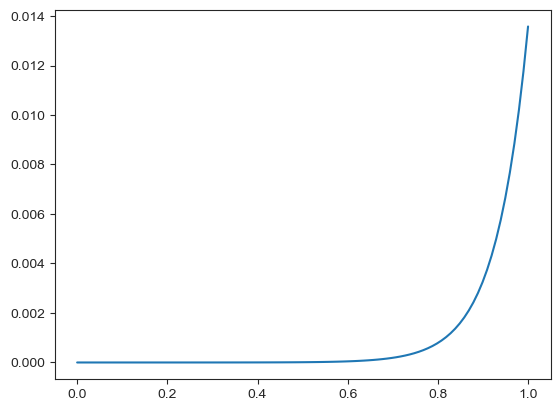

In [94]:
### Plot how the intensity scaling looks like..
xs= np.linspace(0, 1, 100)
ys = intensity_function(xs)
plt.plot(xs, ys)
plt.show()

In [95]:
def combine_molecules_intensity_weighed(label, dataset, mixtures_IDs, CID2features, mixtures_intensities):
    # Grab the unique data row:
    row = mixtures_IDs[(mixtures_IDs['Mixture Label'] == label) & (mixtures_IDs['Dataset'] == dataset)]
    # The intensity of that data row:
    intesnity_row = mixtures_intensities[(mixtures_intensities['Mixture Label'] == label) & (mixtures_intensities['Dataset'] == dataset)]
    
    non_zero_CIDs = row.loc[:, row.columns.str.contains('CID')].loc[:, (row != 0).any(axis=0)]
    non_zero_intensities = intesnity_row.loc[:, intesnity_row.columns.str.contains('CID')].loc[:, (intesnity_row != 0).any(axis=0)]
    if len(non_zero_CIDs) != 1:
        print('Not a Unique pointer!!!')
    CIDs = non_zero_CIDs.iloc[0].tolist()
    intensities = non_zero_intensities.iloc[0].tolist()
    CID2intensity = dict(zip(CIDs, intensities))

    molecule_embeddings = []
    # Create feature matrix for all number of mono odor molecules in the mixture:
    for CID in CIDs:
        molecule_embeddings.append(np.array(CID2features[CID])*intensity_function(CID2intensity[CID]/100))

    # Combine by sum across molecules:
    mixture_embedding = np.nansum(molecule_embeddings, axis=0)
    
    return mixture_embedding

In [96]:
X = []
y = []
num_monos = []
CIDs_all = []

for _, row in training_set.iterrows():
    mixture1 = combine_molecules_intensity_weighed(label=row['Mixture 1'], dataset=row['Dataset'],
                                            mixtures_IDs=mixtures_IDs, CID2features=CID2features,
                                            mixtures_intensities= mixtures_intensities)
    mixture2 = combine_molecules_intensity_weighed(label=row['Mixture 2'], dataset=row['Dataset'],
                                            mixtures_IDs=mixtures_IDs, CID2features=CID2features,
                                            mixtures_intensities= mixtures_intensities)
    X.append((mixture1, mixture2))
    y.append(row['Experimental Values'])

In [97]:
_, _, num_mixtures, all_pairs_CIDs = format_Xy(training_set,  mixtures_IDs, CID2features, method = 'avg')

- each `x` in `X` contains a two vector tuple `(mixture_1, mixture_2)`, index ordered same way as `training_set`
- `method` specifies the ways to create the mixture embeeding from 

In [98]:
# Convert the input pairs to a suitable format for training
X_pairs = np.array([(np.concatenate((x1, x2))) for x1, x2 in X])
y_true = np.array(y)

In [99]:
distances_1 = [get_euclidean_distance(m[0][:96], m[1][:96]) for m in X]
similarities_1 = [get_cosine_similarity(m[0][:96], m[1][:96]) for m in X]
angles_1 = [get_cosine_angle(m[0][:96], m[1][:96]) for m in X]

distances_2 = [get_euclidean_distance(m[0][96:], m[1][96:]) for m in X]
similarities_2 = [get_cosine_similarity(m[0][96:], m[1][96:]) for m in X]
angles_2 = [get_cosine_angle(m[0][96:], m[1][96:]) for m in X]

In [100]:
shared_monos = [ len( set(pair[0]).intersection(set(pair[1]))) for pair in all_pairs_CIDs]
diff_monos = [ len( set(pair[0]).difference(set(pair[1]))) for pair in all_pairs_CIDs]

In [101]:
datasets = training_set['Dataset'].to_numpy()
encoder = OneHotEncoder()
data_arr = encoder.fit_transform(datasets.reshape(-1, 1))
data_arr = data_arr.toarray()

In [102]:
### add all information above
X_features = np.hstack((X_pairs, 
                        np.array(distances_1).reshape(500, 1), 
                        np.array(similarities_1).reshape(500, 1), 
                        np.array(angles_1).reshape(500, 1), 
                        np.array(distances_2).reshape(500, 1), 
                        np.array(similarities_2).reshape(500, 1), 
                        np.array(angles_2).reshape(500, 1), 
                        np.array(shared_monos).reshape(500, 1), 
                        np.array(diff_monos).reshape(500, 1), 
                        np.array(num_mixtures), 
                        data_arr))

### Correlation between combined mixture embeddings and eperimetal values

In [103]:
dist_corr = np.corrcoef(distances_1, y_true)[0, 1]
print('R (Reduced Mordred embedding Eucledian distance v.s Experimental Value): ', dist_corr)

angle_corr = np.corrcoef(angles_1, y_true)[0, 1]
print('R (Reduced Mordred Vector angle v.s. Experimental Value): ', angle_corr)

angle_corr = np.corrcoef(angles_1, y_true)[0, 1]
print('R (Reduced Mordred Vector angle v.s. Experimental Value): ', angle_corr)

print()

dist_corr = np.corrcoef(distances_2, y_true)[0, 1]
print('R (Deepnose embedding Eucledian distance v.s Experimental Value): ', dist_corr)

angle_corr = np.corrcoef(angles_2, y_true)[0, 1]
print('R (Deepnose Vector angle v.s. Experimental Value): ', angle_corr)

angle_corr = np.corrcoef(angles_2, y_true)[0, 1]
print('R (Deepnose Vector angle v.s. Experimental Value): ', angle_corr)


R (Reduced Mordred embedding Eucledian distance v.s Experimental Value):  0.02601434537261113
R (Reduced Mordred Vector angle v.s. Experimental Value):  0.48268904910113236
R (Reduced Mordred Vector angle v.s. Experimental Value):  0.48268904910113236

R (Deepnose embedding Eucledian distance v.s Experimental Value):  0.02965487375209579
R (Deepnose Vector angle v.s. Experimental Value):  0.5117215791568482
R (Deepnose Vector angle v.s. Experimental Value):  0.5117215791568482


In [104]:
training_set['Eucledian Dist'] = distances_1
training_set['Cosyne Sim'] = similarities_1
training_set['Angle'] = angles_1

training_set['Eucledian Dist'] = distances_1
training_set['Cosyne Sim'] = similarities_1
training_set['Angle'] = angles_1

training_set['Sum num monos'] = np.array(num_mixtures).sum(axis = 1)
training_set['Shared'] = shared_monos
training_set['Diff'] = diff_monos
training_set['Num mixture1'] = np.array(num_mixtures)[:, 0]
training_set['Num mixture2'] = np.array(num_mixtures)[:, 1]

----
## 2. Training
### 2.1 Example attempt, standard intialized RF and XGBoost

In [108]:
n_folds = 10
# seed = 314159
seed = 98


In [109]:
rf_best =   {'n_estimators': 400, 'min_samples_split': 2, 'max_features': 'auto', 'max_depth': 20, 'bootstrap': True}
xgb_best = {'subsample': 0.7, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 0.5}

In [110]:
rf_pred_list = []
xgb_pred_list = []
y_true_list = []
test_indices_list = []  # Keep track of the test indices in each fold

# Perform k-fold cross-validation:
kf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
for train_index, test_index in kf.split(X_features):
    X_train, X_test = X_features[train_index], X_features[test_index]
    y_train, y_test = y_true[train_index], y_true[test_index]
    
    # Train the Random Forest regressor
    # rf = RandomForestRegressor(n_estimators = 100, random_state=seed)
    rf = RandomForestRegressor(**rf_best, random_state=seed)

    rf.fit(X_train, y_train)
    
    # Train the XGBoost regressor
    # xgb_model = xgb.XGBRegressor(n_estimators = 100, random_state=seed)
    xgb_model = xgb.XGBRegressor(**xgb_best, random_state=seed)
    xgb_model.fit(X_train, y_train)
    
    # Make predictions 
    rf_pred = rf.predict(X_test)
    xgb_pred = xgb_model.predict(X_test)
    
    rf_pred_list.extend(rf_pred)
    xgb_pred_list.extend(xgb_pred)
    y_true_list.extend(y_test)
    test_indices_list.extend(test_index)  # Store the test indices

# Store the predictions and actual values
results_df = pd.DataFrame({
    'test_index': test_indices_list,
    'rf_pred': rf_pred_list,
    'xgb_pred': xgb_pred_list,
    'y_true': y_true_list
})

# Merge the results with the training_set df
training_set = training_set.merge(results_df, left_index=True, right_on='test_index')
training_set.drop('test_index', axis=1, inplace=True)

/Users/xinzheng/opt/anaconda3/envs/feedback/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/xinzheng/opt/anaconda3/envs/feedback/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/xinzheng/opt/anaconda3/envs/feedback/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `ma

In [111]:
# Calculate the correlation and R^2 for Random Forest
rf_corr = np.corrcoef(rf_pred_list, y_true_list)[0, 1]
rf_rmse = np.sqrt(mean_squared_error(np.array(y_true_list), np.array(rf_pred_list)))

print(f"Random Forest - R: {rf_corr:.3f}")
print(f"Random Forest - RMSE: {rf_rmse:.3f}")
print()
# Calculate the correlation and R^2 for XGBoost
xgb_corr = np.corrcoef(xgb_pred_list, y_true_list)[0, 1]
xgb_rmse = np.sqrt(mean_squared_error(np.array(y_true_list), np.array(xgb_pred_list)))

print(f"XGBoost - R: {xgb_corr:.3f}")
print(f"XGBoost - RMSE: {xgb_rmse:.3f}")

Random Forest - R: 0.638
Random Forest - RMSE: 0.121

XGBoost - R: 0.644
XGBoost - RMSE: 0.120


In [112]:
# Get the unique dataset names
datasets = training_set['Dataset'].unique()

# Iterate over each dataset and fit a linear regression
for dataset in datasets:
    # Filter the data for the current dataset
    subset = training_set[training_set['Dataset'] == dataset]
    
    # Extract the features (rf_pred) and target (y_true)
    X = subset[['rf_pred']].values
    y = subset['y_true'].values
    
    # Create and fit the linear regression model
    model = LinearRegression()
    model.fit(X, y)
    
    # Get the slope of the regression line
    slope = model.coef_[0]
    
    print(f"Slope for {dataset}: {slope:.3f}")

Slope for Snitz 1: 1.287
Slope for Snitz 2: 1.419
Slope for Ravia: 1.049
Slope for Bushdid: 0.963


/Users/xinzheng/opt/anaconda3/envs/feedback/lib/python3.11/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


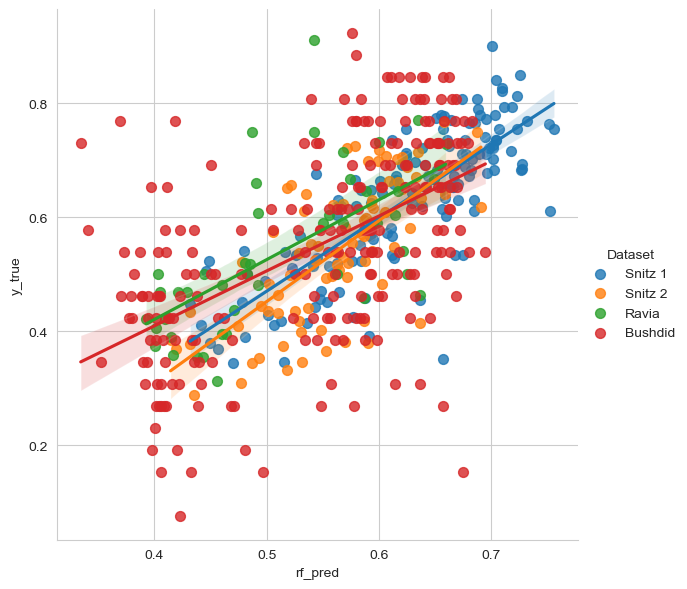

In [113]:
sns.set_style('whitegrid')
fig = sns.lmplot(data=training_set, x='rf_pred', y='y_true', hue='Dataset', height=6, aspect=1, scatter_kws={'s': 50})
plt.show()

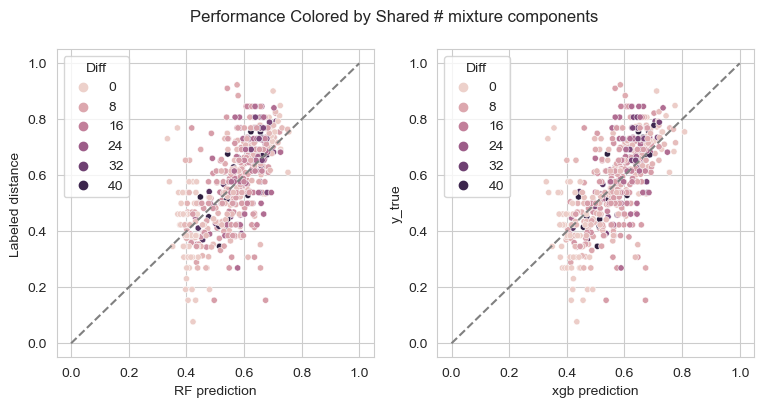

In [114]:
fig, ax = plt.subplots(ncols = 2, figsize = (9, 4))
sns.scatterplot(data = training_set, x = 'rf_pred', y = 'y_true', hue = 'Diff', ax = ax[0], s = 20)
ax[0].set_xlabel("RF prediction")
ax[0].set_ylabel("Labeled distance")
ax[0].plot([0, 1],[0, 1], c = 'gray', ls = '--')

sns.scatterplot(data = training_set, x = 'xgb_pred', y = 'y_true', hue = 'Diff', ax = ax[1], s = 20)
ax[1].set_xlabel("xgb prediction")
ax[1].plot([0, 1],[0, 1], c = 'gray', ls = '--')

fig.suptitle('Performance Colored by Shared # mixture components')

plt.show()

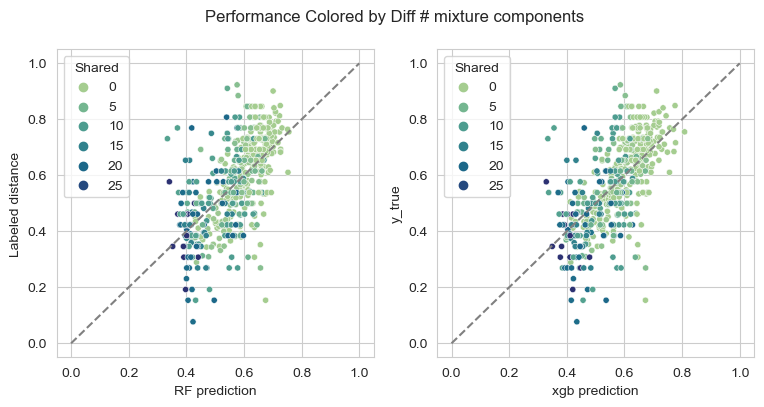

In [115]:
fig, ax = plt.subplots(ncols = 2, figsize = (9, 4))
sns.scatterplot(data = training_set, x = 'rf_pred', y = 'y_true', hue = 'Shared', ax = ax[0], s = 20, palette= 'crest')
ax[0].set_xlabel("RF prediction")
ax[0].set_ylabel("Labeled distance")
ax[0].plot([0, 1],[0, 1], c = 'gray', ls = '--')

sns.scatterplot(data = training_set, x = 'xgb_pred', y = 'y_true', hue = 'Shared', ax = ax[1], s = 20, palette= 'crest')
ax[1].set_xlabel("xgb prediction")
ax[1].plot([0, 1],[0, 1], c = 'gray', ls = '--')
fig.suptitle('Performance Colored by Diff # mixture components')

plt.show()

In [116]:
training_set

,Dataset,Mixture 1,Mixture 2,Experimental Values,Eucledian Dist,Cosyne Sim,Angle,Sum num monos,Shared,Diff,Num mixture1,Num mixture2,rf_pred,xgb_pred,y_true
400,Snitz 1,1,2,0.604167,0.000007,-0.134261,1.705464,20,0,10,10,10,0.562767,0.553746,0.604167
150,Snitz 1,1,3,0.651042,0.000005,-0.039089,1.609896,11,0,10,10,1,0.658066,0.658350,0.651042
450,Snitz 1,1,5,0.505208,0.000010,-0.196405,1.768486,40,0,10,10,30,0.446183,0.411838,0.505208
0,Snitz 1,1,6,0.411458,0.000011,-0.212604,1.785036,50,0,10,10,40,0.506786,0.513484,0.411458
350,Snitz 1,1,7,0.562500,0.000006,-0.062832,1.633670,14,0,10,10,4,0.594639,0.572189,0.562500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,Bushdid,509,510,0.461538,0.000006,0.675605,0.829012,60,20,10,30,30,0.422448,0.431070,0.461538
199,Bushdid,513,514,0.692308,0.000010,-0.193110,1.765127,40,0,20,20,20,0.605303,0.605338,0.692308
99,Bushdid,515,516,0.730769,0.000006,0.291459,1.275044,20,3,7,10,10,0.610217,0.680974,0.730769
299,Bushdid,517,518,0.538462,0.000010,-0.171136,1.742779,40,0,20,20,20,0.694674,0.685101,0.538462


In [117]:
training_set.groupby('Dataset')['rf_pred', 'y_true'].apply(
    lambda x: abs(x['rf_pred'] - x['y_true']).mean())

/var/folders/63/lv4_06n90jx2p5v2t58ssgwr0000gp/T/ipykernel_52340/3348153056.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  training_set.groupby('Dataset')['rf_pred', 'y_true'].apply(


Dataset
Bushdid    0.118340
Ravia      0.079191
Snitz 1    0.063304
Snitz 2    0.077232
dtype: float64

In [118]:
training_set.groupby('Dataset')['xgb_pred', 'y_true'].apply(
    lambda x: abs(x['xgb_pred'] - x['y_true']).mean())

/var/folders/63/lv4_06n90jx2p5v2t58ssgwr0000gp/T/ipykernel_52340/2246081906.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  training_set.groupby('Dataset')['xgb_pred', 'y_true'].apply(


Dataset
Bushdid    0.120110
Ravia      0.076774
Snitz 1    0.058398
Snitz 2    0.066729
dtype: float64

In [32]:
for seed in [1, 2, 3]:
    rf_best, rgb_best = para_search(seed, X_features, y_true)
    _ =  avg_rf_best(rf_best, X_features, y_true)
    _ =  avg_rgb_best(rgb_best, X_features, y_true)

/Users/xinzheng/opt/anaconda3/envs/feedback/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/xinzheng/opt/anaconda3/envs/feedback/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/xinzheng/opt/anaconda3/envs/feedback/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `ma

Best Random Forest model:
Hyperparameters: {'n_estimators': 400, 'min_samples_split': 2, 'max_features': 'auto', 'max_depth': 20, 'bootstrap': True}
Correlation: 0.9750694343491063
RMSE: 0.04509892662078433

Best XGBoost model:
Hyperparameters: {'subsample': 0.7, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 0.5}
Correlation: 0.997247751525405
RMSE: 0.015569053295514194


/Users/xinzheng/opt/anaconda3/envs/feedback/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/xinzheng/opt/anaconda3/envs/feedback/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/xinzheng/opt/anaconda3/envs/feedback/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `ma

RandomForest Average Performance:
R mean: 0.6392017624024392
R std: 0.006384713497650123
RMSE mean: 0.12066172317965651
RMSE std: 0.0008327914020346979
XGBoost Average Performance:
R mean: 0.6416206117007875
R std: 0.004993599179229569
RMSE mean: 0.12002062605743546
RMSE std: 0.0004988276960423697


/Users/xinzheng/opt/anaconda3/envs/feedback/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/xinzheng/opt/anaconda3/envs/feedback/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/xinzheng/opt/anaconda3/envs/feedback/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `ma

Best Random Forest model:
Hyperparameters: {'n_estimators': 300, 'min_samples_split': 5, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}
Correlation: 0.9695898768500417
RMSE: 0.0488929962414737

Best XGBoost model:
Hyperparameters: {'subsample': 0.5, 'n_estimators': 400, 'max_depth': 9, 'learning_rate': 0.01, 'colsample_bytree': 0.7}
Correlation: 0.9907849993050293
RMSE: 0.030228983881941243


/Users/xinzheng/opt/anaconda3/envs/feedback/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/xinzheng/opt/anaconda3/envs/feedback/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/xinzheng/opt/anaconda3/envs/feedback/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `ma

RandomForest Average Performance:
R mean: 0.6366789798011225
R std: 0.00729065290571185
RMSE mean: 0.12098538646704285
RMSE std: 0.0009030288595445332
XGBoost Average Performance:
R mean: 0.6389033336767542
R std: 0.005040002910868844
RMSE mean: 0.12068812961451691
RMSE std: 0.0005998395342392953


/Users/xinzheng/opt/anaconda3/envs/feedback/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/xinzheng/opt/anaconda3/envs/feedback/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/xinzheng/opt/anaconda3/envs/feedback/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `ma

Best Random Forest model:
Hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}
Correlation: 0.9756407918376239
RMSE: 0.04492697216954169

Best XGBoost model:
Hyperparameters: {'subsample': 0.5, 'n_estimators': 400, 'max_depth': 9, 'learning_rate': 0.01, 'colsample_bytree': 0.7}
Correlation: 0.9911552745510566
RMSE: 0.029668914011215956


/Users/xinzheng/opt/anaconda3/envs/feedback/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/xinzheng/opt/anaconda3/envs/feedback/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/xinzheng/opt/anaconda3/envs/feedback/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `ma

RandomForest Average Performance:
R mean: 0.6386410657485048
R std: 0.007080115349275251
RMSE mean: 0.12069899021643193
RMSE std: 0.0010337512749559472
XGBoost Average Performance:
R mean: 0.6389033336767542
R std: 0.005040002910868844
RMSE mean: 0.12068812961451691
RMSE std: 0.0005998395342392953
